## 1. Introduction
The project I have chosen is to predict whether an asteroid is classified as hazardous(0) or non-hazardous(1) based on a large number of parameters such as diameter, eccentricity of orbit etc. I obtained the data from NASA's Small-Body Database Query and uploaded it into the class's git page where I will be pulling the data from for this project. This data contains approximately 32000 data points, each with 41 variables, excluding whether it is hazardous. However, the data is extremely biased, with approximately 90% of the data points classified as non-hazardous. As a result, I chose to use undersampling here in order to combat this biasedness. Therefore, we will be using approximately a total of approximately 5000 data points, with equal numbers of 0s and 1s. This dataset also contains missing values, with some of the variables being almost 90% empty. Therefore, we will choose to eliminate these variables since there is a lack of data there. Next, we will impute the missing values in the remaining columns by taking the median of that specific variable.

We split the dataset into 80% training and 20% testing. We create a simple artifical neural network with 3 hidden layers with ReLU activation functions and sigmoid for the ouput to obtain a value of 0 to 1 for binary classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
from torch import nn
import torch.optim
import torch.utils.data

### Section 2. Data

In [2]:
# Data has been filtered and redundant columns have been removed during the query.
data = pd.read_csv("https://raw.githubusercontent.com/jetwidjaja/Asteroid-Risk-Project/main/asteroid_data.csv", low_memory=False)

branch = ('pha', 'H', 'G', 'diameter', 'albedo', 'rot_per', 'GM', 'BV', 'UB',
       'diameter_sigma', 'epoch_cal', 'e', 'a', 'q', 'i', 'om', 'w', 'ma',
       'ad', 'n', 'tp', 'per_y', 'moid', 'moid_jup', 't_jup', 'sigma_e',
       'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma',
       'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'data_arc',
       'condition_code', 'rms'
         )


# Replace all the Y/N to the boolean values True/False represented by 0 and 1.as_integer_ratio
data.pha = data.pha.replace(to_replace={'Y':0, 'N':1})

# Remove the columns without much information
data = data.drop(columns=['M1', 'M2', 'K1', 'K2', 'PC', 'DT', 'IR', 'spec_B', 'spec_T', 'H_sigma', 'equinox', 'first_obs', 'last_obs', 'A1', 'A2', 'A3', 'DT', 'class', 'extent', 'two_body', 'n_obs_used', 'n_del_obs_used', 'n_dop_obs_used'])


pd.set_option('display.max_columns', None)
data.describe()



,pha,H,G,diameter,albedo,rot_per,GM,BV,UB,diameter_sigma,epoch_cal,e,a,q,i,om,w,ma,ad,n,tp,per_y,moid,moid_jup,t_jup,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,data_arc,condition_code,rms
count,28909.000000,28935.000000,13.000000,1249.000000,1204.000000,1882.000000,5.000000e+00,38.000000,38.000000,1161.000000,2.894100e+04,28941.000000,28941.000000,28941.000000,28941.000000,28941.000000,28941.000000,28941.000000,28941.000000,28941.000000,2.894100e+04,28941.000000,2.890900e+04,28909.000000,28941.000000,2.890900e+04,2.890900e+04,2.890900e+04,2.890900e+04,2.890900e+04,2.890900e+04,2.890900e+04,2.890900e+04,2.890900e+04,2.890900e+04,2.890900e+04,28698.000000,28939.000000,28941.000000
mean,0.922377,23.226918,0.114615,1.032639,0.172469,18.199570,8.927385e-05,0.814263,0.416500,0.143618,2.020181e+07,0.439569,1.768543,0.914129,12.239821,172.416157,182.345907,172.564040,2.622966,0.524158,2.458965e+06,2.658533,8.917419e-02,2.701926,4.270479,4.923052e-03,3.060235e-02,2.607403e-03,1.023336e-01,2.508427e-01,4.974814e-01,1.450463e+00,5.188833e-02,5.024503e-03,3.067537e+00,5.524750e+01,1375.334971,5.113411,0.479934
std,0.267582,2.947543,0.238594,1.650398,0.143985,74.999567,1.995837e-04,0.091066,0.102057,0.264608,4.125326e+04,0.177002,2.057165,0.228451,10.898456,103.691657,104.371052,122.234487,4.095104,0.282843,1.480806e+03,33.762979,1.002533e-01,0.965914,1.073523,1.251711e-01,1.217805e+00,7.159082e-02,3.128012e+00,1.665883e+01,1.535223e+01,1.241482e+02,2.269192e+00,1.314449e-01,2.969312e+02,4.305720e+03,3038.871484,3.217407,0.126251
min,0.000000,9.220000,-0.250000,0.002500,0.009000,0.003298,2.100000e-09,0.640000,0.160000,0.000000,1.979121e+07,0.002800,0.461700,0.070000,0.010000,0.020000,0.020000,0.000000,0.650000,0.000175,2.444268e+06,0.314000,1.820000e-07,0.000804,-1.210000,7.000000e-11,4.700000e-11,2.300000e-10,6.900000e-09,5.600000e-08,6.400000e-08,4.300000e-08,5.400000e-11,5.200000e-11,2.300000e-08,2.600000e-08,1.000000,0.000000,0.043245
25%,1.000000,21.000000,-0.030000,0.310000,0.047750,2.246625,4.890400e-09,0.763750,0.368500,0.020000,2.021052e+07,0.307800,1.299000,0.788000,4.490000,81.770000,92.710000,49.880000,1.680000,0.306600,2.459091e+06,1.480000,1.410000e-02,1.960000,3.430000,6.500000e-07,1.600000e-07,6.100000e-07,4.100000e-05,5.600000e-05,1.200000e-04,2.400000e-04,2.400000e-07,6.800000e-08,3.100000e-04,1.200000e-04,7.000000,1.000000,0.394250
50%,1.000000,23.500000,0.100000,0.629000,0.137000,4.773500,3.000000e-08,0.830000,0.454500,0.050000,2.022012e+07,0.453500,1.699000,0.963000,8.610000,171.670000,184.370000,166.510000,2.450000,0.445100,2.459486e+06,2.210000,4.890000e-02,2.850000,4.030000,1.600000e-04,3.200000e-04,2.600000e-05,2.000000e-03,5.500000e-04,1.900000e-03,5.300000e-02,4.500000e-04,1.700000e-04,2.400000e-02,2.200000e-01,27.000000,6.000000,0.470240
75%,1.000000,25.400000,0.240000,1.245000,0.254500,11.467500,3.224000e-08,0.869500,0.490000,0.170000,2.022012e+07,0.566300,2.178000,1.064000,17.210000,253.580000,272.480000,292.290000,3.370000,0.665500,2.459691e+06,3.210000,1.350000e-01,3.540000,4.900000,8.900000e-04,2.700000e-03,1.800000e-04,1.400000e-02,3.900000e-03,1.300000e-02,2.600000e-01,3.900000e-03,1.100000e-03,2.800000e-01,1.900000e+00,1257.000000,8.000000,0.553230
max,1.000000,33.200000,0.600000,37.675000,0.856000,1880.000000,4.463000e-04,1.022000,0.531000,3.780000,2.022051e+07,0.996100,316.600000,1.300000,165.540000,359.980000,360.000000,360.000000,631.900000,3.141000,2.460749e+06,5630.000000,7.080000e-01,4.620000,11.600000,1.600000e+01,1.400000e+02,8.200000e+00,3.400000e+02,2.700000e+03,2.200000e+03,2.100000e+04,2.700000e+02,1.700000e+01,5.000000e+04,6.500000e+05,46582.000000,9.000000,2.898600


In [3]:
# Data is biased, so we use undersampling
yes = data[data.pha == 0]
no = data[data.pha == 1]

class_no, class_yes = data.pha.value_counts()

df_no = no.sample(class_yes)


undersampled_data = pd.concat([yes, df_no])

print(len(undersampled_data))


4488


In [4]:
# Find number of missing data in each column
data_boolean = undersampled_data.isnull()
data_boolean = np.array(data_boolean)

for i in range(len(branch)):
    x = 0
    for j in range(len(data_boolean)):
        if data_boolean[j,i] == True:
            x = x + 1
        else:
            x = x
    print('Number of missing values of', branch[i], '=', x)


Number of missing values of pha = 0
Number of missing values of H = 1
Number of missing values of G = 4480
Number of missing values of diameter = 4073
Number of missing values of albedo = 4097
Number of missing values of rot_per = 3856
Number of missing values of GM = 4484
Number of missing values of BV = 4475
Number of missing values of UB = 4475
Number of missing values of diameter_sigma = 4107
Number of missing values of epoch_cal = 0
Number of missing values of e = 0
Number of missing values of a = 0
Number of missing values of q = 0
Number of missing values of i = 0
Number of missing values of om = 0
Number of missing values of w = 0
Number of missing values of ma = 0
Number of missing values of ad = 0
Number of missing values of n = 0
Number of missing values of tp = 0
Number of missing values of per_y = 0
Number of missing values of moid = 0
Number of missing values of moid_jup = 0
Number of missing values of t_jup = 0
Number of missing values of sigma_e = 0
Number of missing va

In [5]:
# Remove columns with significant missing data
remove_columns = ['G', 'albedo', 'rot_per', 'GM', 'BV', 'UB', 'diameter_sigma']
filtered_data = undersampled_data.drop(columns=remove_columns)

# The method we use to impute missing values is to use the median values for their respective columns
data_impute = filtered_data

branch = ('pha', 'H', 'diameter',  'epoch_cal', 'e', 'a', 'q', 'i', 'om', 'w', 'ma',
       'ad', 'n', 'tp', 'per_y', 'moid', 'moid_jup', 't_jup', 'sigma_e',
       'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w', 'sigma_ma',
       'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'data_arc',
       'condition_code', 'rms'
         )
         
for column in branch:
    data_impute[column] = data_impute[column].fillna(data_impute[column].median())

# Normalize the dataset
scaler = MinMaxScaler()
scaler.fit(data_impute)
scaled = scaler.fit_transform(data_impute)
scaled_data = pd.DataFrame(scaled, columns=data_impute.columns)

# Split the data into test and training sets since the data is already randomnized.
train, test = model_selection.train_test_split(scaled_data, test_size=0.2, random_state=123)

# Seperate into x and y test and training sets
x_train = train.drop(columns=['pha'])
y_train = train.pha

x_test = test.drop(columns=['pha'])
y_test = test.pha


x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)

x_test = torch.tensor(np.array(x_test), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32)

# Convert the y_train and y_test to 2d tensor.
y_train = y_train.view(len(y_train), 1)
y_test = y_test.view(len(y_test), 1)



## Section 3. Network

In [6]:
class Net(torch.nn.Module):
    def __init__(self, input=len(data_impute.columns)-1, output=1, hidden_layer_1=64, hidden_layer_2=128, hidden_layer_3=32):
        super(Net, self).__init__()

        self.ANN = nn.Sequential(
            nn.Linear(input, hidden_layer_1),
            nn.ReLU(),
            nn.Linear(hidden_layer_1, hidden_layer_2),
            nn.ReLU(),
            nn.Linear(hidden_layer_2, hidden_layer_3),
            nn.ReLU(),
            nn.Linear(hidden_layer_3, output),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.ANN(x)

        return x

net = Net()
torch.save(net.state_dict(), 'net.pth')

## Section 4. Parameters

In [7]:
# Binary Classification problem, so we use BCE loss       
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

x_train_split = torch.utils.data.DataLoader(x_train, batch_size=32, shuffle = False)
y_train_split = torch.utils.data.DataLoader(y_train, batch_size=32, shuffle = False)

## Section 5. Execution

In [8]:
train_loss = []
test_loss = []

torch.manual_seed(123)
net.train()

for epoch in range(500):
    for x_batch, y_batch in zip(x_train_split, y_train_split):
        y_pred = net(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(loss.data)
    net.eval()
    pred = net(x_test)
    testloss = loss_fn(pred, y_test)
    test_loss.append(testloss.data)

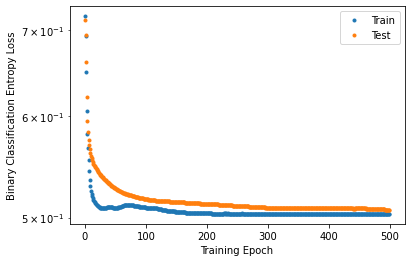

In [9]:
plt.plot(train_loss, '.', label="Train")
plt.plot(test_loss, '.', label='Test')
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Binary Classification Entropy Loss')
plt.yscale('log')

## Section 6. Results

In [10]:
# Passing the x test dataset through the ANN model
pred = net(x_test)

# Change probability output into arbitrary 1s and 0s by setting threshold at 0.5
pred = torch.where(pred>torch.tensor(0.5), torch.tensor(1.), torch.tensor(0.))

matrix = torch.cat((pred, y_test),1)


# Finding the accuracy of the prediction dataset
correct = 0
for i in range(len(matrix)):
    if matrix[i,0] == matrix[i,1]:
        correct = correct + 1

    else:
        correct = correct

print('Accuracy =', correct/len(matrix)*100, '%')


Accuracy = 97.88418708240535 %


ROC score = 0.9790947944226313


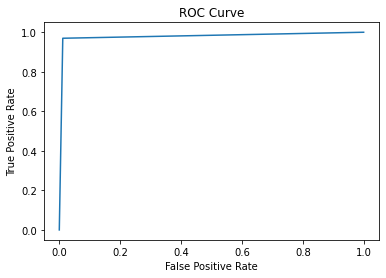

In [11]:
FPR, TPR, threshold = roc_curve(y_test, pred)
score = roc_auc_score(y_test, pred)

print('ROC score =', score)

plt.plot(FPR, TPR)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Section 7. Optimization

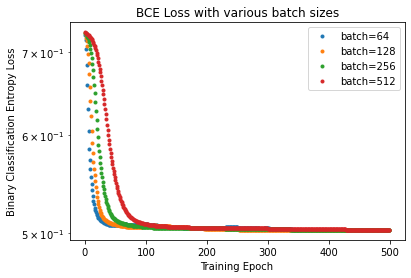

In [12]:
torch.manual_seed(123)
net.train()

# Various BCE loss for different batch size
for batch_size in (64, 128, 256, 512):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    net.load_state_dict(torch.load('net.pth'))
    x_train_split = torch.utils.data.DataLoader(x_train, batch_size, shuffle = False)
    y_train_split = torch.utils.data.DataLoader(y_train, batch_size, shuffle = False)
    losses = []

    for epoch in range(500):
        for x_batch, y_batch in zip(x_train_split, y_train_split):
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
    plt.plot(losses, '.', label=f'batch={batch_size}')
plt.legend()
plt.title('BCE Loss with various batch sizes')
plt.xlabel('Training Epoch')
plt.ylabel('Binary Classification Entropy Loss')
plt.yscale('log')
plt.show()    

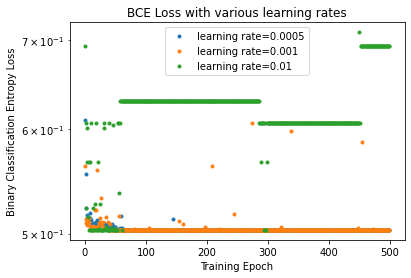

In [13]:
torch.manual_seed(123)
net.train()

# Various BCE loss for different learning rates
for learning_rate in (0.0005, 0.001, 0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    net.load_state_dict(torch.load('net.pth'))
    x_train_split = torch.utils.data.DataLoader(x_train, batch_size=32, shuffle = False)
    y_train_split = torch.utils.data.DataLoader(y_train, batch_size=32, shuffle = False)
    losses = []

    for epoch in range(500):
        for x_batch, y_batch in zip(x_train_split, y_train_split):
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.data)
    plt.plot(losses, '.', label=f'learning rate={learning_rate}')
plt.legend()
plt.title('BCE Loss with various learning rates')
plt.xlabel('Training Epoch')
plt.ylabel('Binary Classification Entropy Loss')
plt.yscale('log')
plt.show()

We can therefore conclude that the parameters I have chosen are relatively optimal for this model.

## References
https://ssd.jpl.nasa.gov/tools/sbdb_query.html

https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/

https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://www.kaggle.com/datasets/shrutimehta/nasa-asteroids-classification

https://www.youtube.com/watch?v=WPQOkoXhdBQ